In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from sklearn.metrics import log_loss
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [3]:
img_rows, img_cols = 224, 224
channel = 3
num_classes = 196
batch_size = 16
nb_epoch = 200
nb_train_samples = 8144
nb_validation_samples = 8041

In [4]:
X_train = 'data/car_data/train/'
X_valid = 'data/car_data/validation/'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    X_train,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)
class_names = list(train_generator.class_indices.keys())
print(class_names)

Found 8144 images belonging to 196 classes.
['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007',

In [8]:
validation_generator = test_datagen.flow_from_directory(
    X_valid,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8041 images belonging to 196 classes.


In [10]:
# build the VGG16 network
input_tensor = Input(shape=(img_rows, img_cols, channel))
model_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [11]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# Add Fully Connected Layer
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(4096, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

In [13]:
model = Model(input=model_vgg.input, output=top_model(model_vgg.output))
for layer in model.layers[:13]:
    layer.trainable = False

c:\users\zhaow\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [14]:
# Learning rate is changed to 0.001
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size, 
    nb_epoch=nb_epoch,
    shuffle=True,
    verbose=1,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size
)

c:\users\zhaow\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
c:\users\zhaow\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=509, shuffle=True, verbose=1, validation_data=<keras_pre..., validation_steps=502, epochs=200)`
  


Epoch 1/200
509/509 [==============================] - 321s 631ms/step - loss: 5.2950 - acc: 0.0056 - val_loss: 5.2777 - val_acc: 0.0082
Epoch 2/200
509/509 [==============================] - 246s 483ms/step - loss: 5.2779 - acc: 0.0083 - val_loss: 5.2772 - val_acc: 0.0087
Epoch 3/200
509/509 [==============================] - 225s 442ms/step - loss: 5.2775 - acc: 0.0086 - val_loss: 5.2774 - val_acc: 0.0061
Epoch 4/200
509/509 [==============================] - 223s 438ms/step - loss: 5.2772 - acc: 0.0082 - val_loss: 5.2764 - val_acc: 0.0085
Epoch 5/200
509/509 [==============================] - 225s 442ms/step - loss: 5.2770 - acc: 0.0081 - val_loss: 5.2760 - val_acc: 0.0086
Epoch 6/200
509/509 [==============================] - 225s 441ms/step - loss: 5.2765 - acc: 0.0082 - val_loss: 5.2756 - val_acc: 0.0083
Epoch 7/200
509/509 [==============================] - 223s 438ms/step - loss: 5.2761 - acc: 0.0082 - val_loss: 5.2753 - val_acc: 0.0086
Epoch 8/200
509/509 [====================

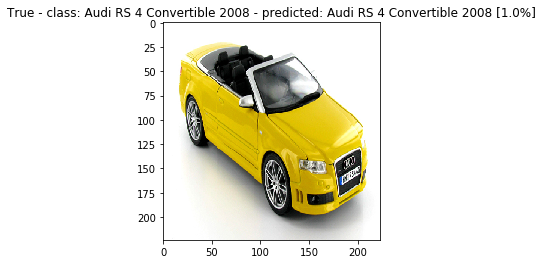

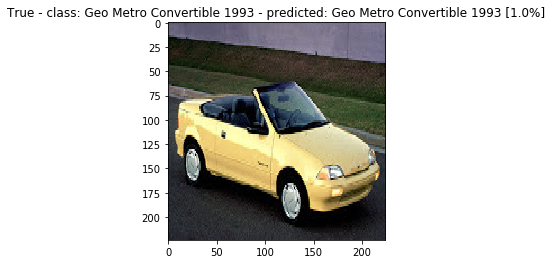

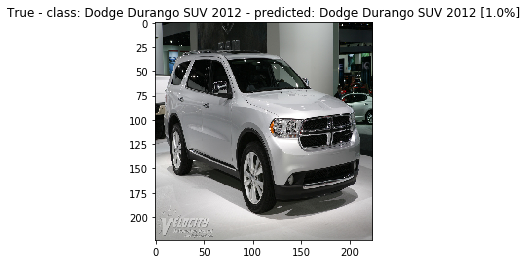

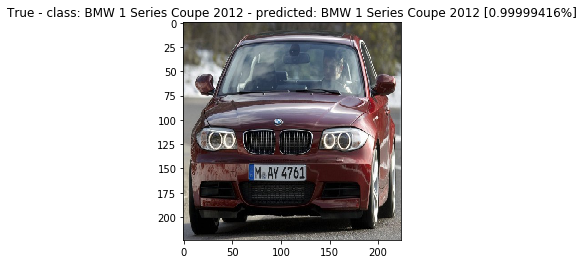

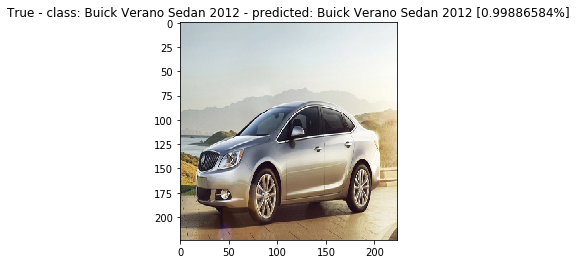

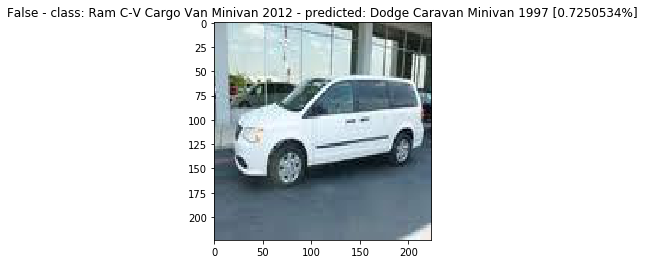

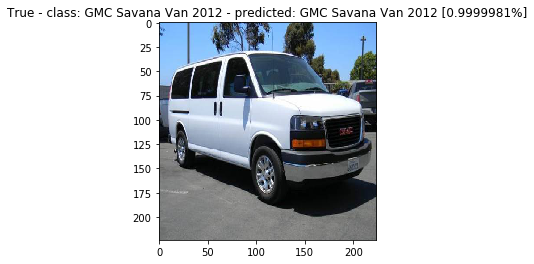

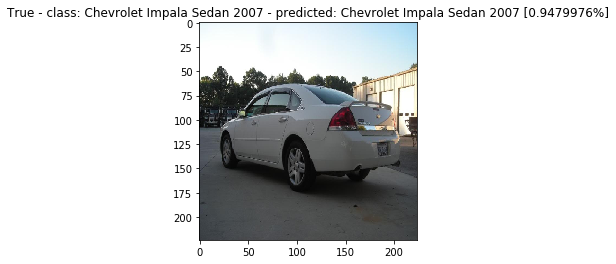

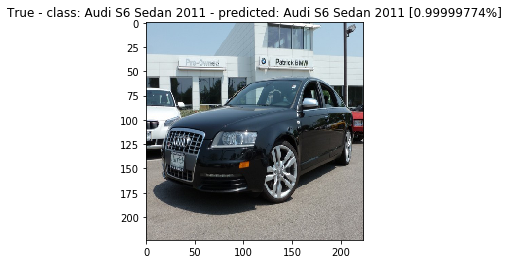

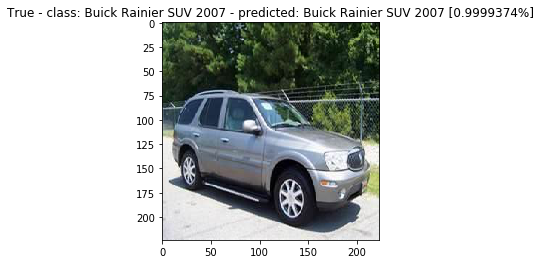

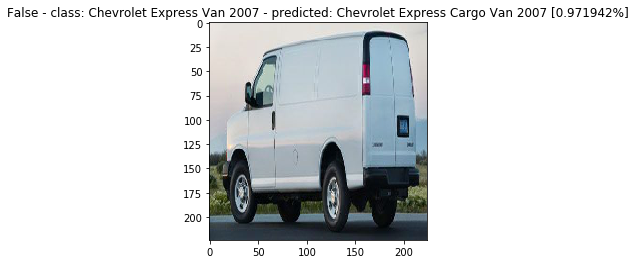

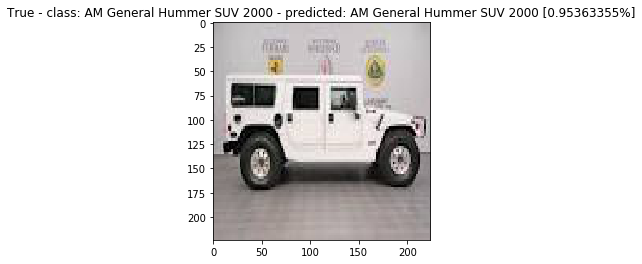

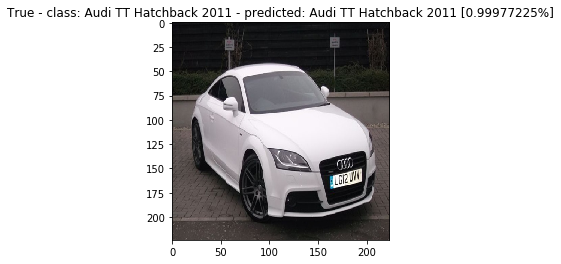

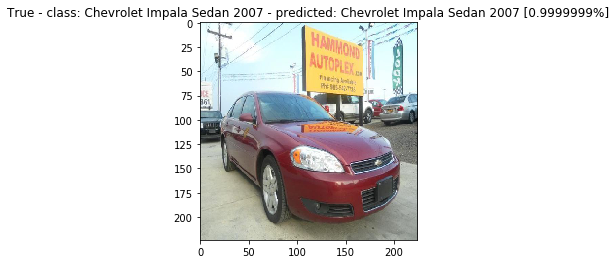

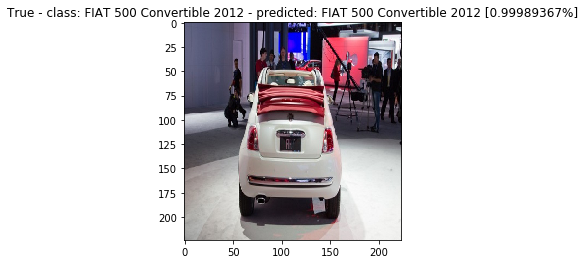

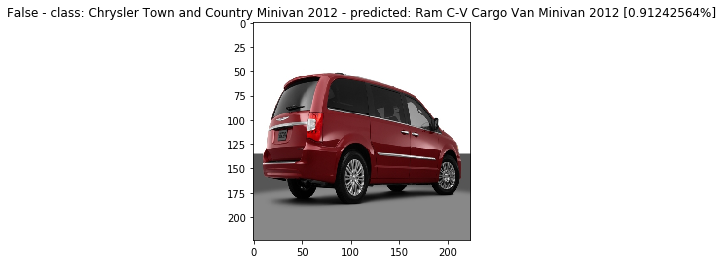

In [16]:
def predict_one(model):
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0, image_batch.shape[0]):
        image = image_batch[k]
        pred = predicted_batch[k]
        the_pred = np.argmax(pred)
        predicted = class_names[the_pred]
        val_pred = max(pred)
        the_class = np.argmax(classes_batch[k])
        value = class_names[np.argmax(classes_batch[k])]
        plt.figure(k)
        isTrue = (the_pred == the_class)
        plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + ' [' + str(val_pred) + '%]')
        plt.imshow(image)
predict_one(model)

In [17]:
model.save('cars2.h5')

In [18]:
# from keras.models import load_model
# model = load_model('cars.h5')

In [19]:
img_path = '01077.jpg'
raw_img = image.load_img(img_path, target_size=(img_rows, img_cols))
img = image.img_to_array(raw_img)

img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

features = model.predict(img)
features

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [20]:
raw_img.show

<bound method Image.show of <PIL.Image.Image image mode=RGB size=224x224 at 0x29F13EE9C88>>

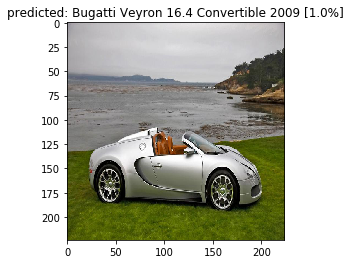

In [21]:
index = np.argmax(features)
label = class_names[index]
plt.title('predicted: ' + label + ' [' + str(features[0, index]) + '%]')
plt.imshow(raw_img)